## Projektinstruktioner

Du ska välja en av 5 uppgifter och försöka lösa problemet med hjälp av djupa neurala nätverk. Varje
uppgift innehåller ett dataset och en problemformulering. Du ska själva ta fram vilken typ av
modell som är lämplig för projektet, träna den, optimera hyperparametrar och utvärdera.

- Du får inte lägga till egen data i projektet, men du ska städa datan.
- Det är tillåtet med dataagumentering för att utöka ditt dataset.
- Du ska skapa en modell från grunden, transfer learning får inte användas.

### Krav för godkänt (G)
- Skapa en modell från grunden. Du ansvarar själv för städning av datan och uppdelning i träning, validering och testning.
**Frågor:**
- Motivera din modell, dess arkitektur och val av relevanta hyperparametrar.
- Har du använt någon databehandling? Varför?
  - felstavning, siffror i ord, ord som är space:ade (hat -> h a t), punkt
- Utvärdera modellens prestanda.
- Är prestandan bra? Varför/ varför inte?
- Vad hade du kunnat göra för att förbättra den ytterligare?

### Krav för väl godkänt (VG)
- För VG ska du utvärdera modellen noggrannare och systematiskt optimera hyperparametrar.
**Frågor:**
- Testa olika hyperparametrar systematiskt.
- Vilken typ av fel gör modellen?
  - Gör den fel på vissa klasser? Gör den fel specifik typ av data? Annat?
  - Kan du göra något för att hantera vanliga fel modellen gör? (Med den data du har, att träna på mer data är inte ett godkänt svar)
- Finns det några begränsningar med modellen?
  - Exempelvis på grund av prestanda eller hur träningsdatan ser ut.

### Presentation
Förutom att lämna in en notebook ska du skapa en presentation (exempelvis en power point) där du ska
presentera ert problem, vad för modell du skapat och hur den presterar. Ni kommer presentera i
smågrupper.

- Presentationen ska vara 10-15 minuter samt 5-10 minuter till frågor.
- Det är obligatoriskt att presentera och vara med under alla presentationer i din grupp.
- Du får vara med och lyssna på andra grupper om du vill.

### Min valda uppgift - Motverka hatretorik

Denna uppgift innehåller hatiska texter riktad mot flera olika grupper och kan därmed vara jobbig för
vissa att genomföra.

På sociala medier och forum skrivs idag mycket hatiska texter, bpde mot personer och grupper. Oftast
bevakas sociala medier och forum av moderatorer, men det är ett tidskrävande arbete och hat sprids
snabbare än vad de hinner jobba. Genom att ha en modell som kan idetifiera denna typ av text så kan vi snabba på moderatorerna arbete och minska att hat sprids.

**Uppgift:** Skapa en modell som kan identifiera om en text är hatisk mot en specifik grupp (och vilken grupp). Det är några typer av hat som ligger i fokus, exempelvis hat baserat å sexalitet eller kön. 

Hat mot exempelvis en yrkesgrupp räknas inte som en hatisk text. 

Dataset: ca 4000 texter, om den är hatisk och i så fall mot vilken grupp.

In [1090]:
import pandas as pd
import numpy as np
from labb_2_functions import *
from spellchecker import SpellChecker
import string
from googletrans import Translator
import random
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Flatten,
    Activation,
    Conv2D,
    MaxPooling2D,
    BatchNormalization,
    Rescaling,
    GlobalAveragePooling2D
)
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import itertools
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras import Sequential, layers, regularizers
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from tensorflow.keras.callbacks import EarlyStopping

pd.set_option('display.max_colwidth', None)

df = pd.read_csv("hate-text.csv")

In [1091]:
# changes column names
df.columns = ['id', 'text', 'label', 'identity']
df.drop(columns=["id"], axis=1, inplace=True)
df["identity"] = df["identity"].fillna("none") # change to none so its not -1 after encoding.

#### Randomly saw that words are misspelled

In [1092]:
# spell = SpellChecker()

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

# def check_spelling(text):
#     words = text.split()
#     misspelled = spell.unknown(words)
#     return [word for word in misspelled]

# # add misspelled words and removes punctuation
df['text'] = df['text'].apply(remove_punctuation)
# list_of_misspelled_words = df['text'].apply(check_spelling)

### Kanske fixa misspellings senare, vet inte hur viktigt det här är tbh

In [1093]:

# # Flatten the list of lists in 'misspelled_words' and get unique words
# unique_misspelled_words = set(word for words_list in list_of_misspelled_words for word in words_list)

# # Count of unique misspelled words
# count_unique_misspelled = len(unique_misspelled_words)

# print(f"Total unique misspelled words: {count_unique_misspelled}")
# print("Unique misspelled words:", unique_misspelled_words)


In [1094]:
# re-use functions from RNN EDA
character_counter = character_counter_for_sentences(df["text"])
word_counter = word_counter_for_sentences(df["text"])

word_or_character_length(50, character_counter)
word_or_character_length(10, word_counter)
print("\n---LENGTH OF SENTENCES IN DATASET---")

print_metrics_for_characters_or_words("Characters", character_counter)
print_metrics_for_characters_or_words("Words", word_counter)


Rows that are ABOVE or EQUAL to 50 characters long: 1538
Rows that are BELOW 50 characters long: 2363

Rows that are ABOVE or EQUAL to 10 characters long: 1558
Rows that are BELOW 10 characters long: 2343

---LENGTH OF SENTENCES IN DATASET---
Median Length Characters: 45
Average Length Characters: 46.71571391950782
Smallest Length Characters: 11
Longest Length Characters: 101 

Median Length Words: 9
Average Length Words: 8.826454755190976
Smallest Length Words: 2
Longest Length Words: 20 



(None, None, None, None)

### Word and Character Distribution

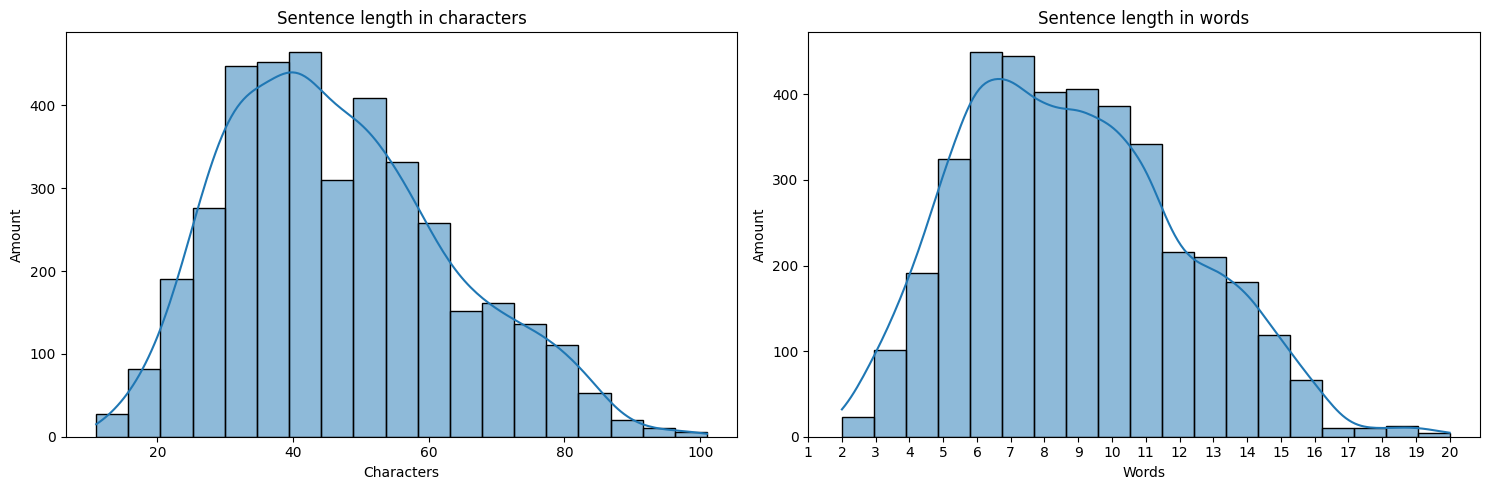

In [1095]:
# Re-using more code from labb 2
texts = df["text"]
character_length = character_counter_for_sentences(texts)
word_length = word_counter_for_sentences(texts)

df["character_amount"] = character_length
df["word_amount"] = word_length

length_words_and_characters_histplot(df, bin=19)
df.drop(columns=['character_amount', 'word_amount'], axis=1, inplace=True)

### Identity Categories

In [1096]:
df["identity"].unique()

array(['women', 'trans people', 'gay people', 'black people',
       'disabled people', 'Muslims', 'immigrants', 'none'], dtype=object)

### Null Values in DF

In [1097]:
df.isnull().sum()

text        0
label       0
identity    0
dtype: int64

In [1098]:
pd.reset_option('display.max_rows')
df[df["identity"].isnull()]

,text,label,identity


### Identity Distribution

In [1099]:
df["identity"].value_counts()

gay people         577
women              535
disabled people    510
Muslims            510
black people       504
trans people       485
immigrants         485
none               295
Name: identity, dtype: int64

### Label Distribution

In [1100]:
df["label"].value_counts()

hateful        2659
non-hateful    1242
Name: label, dtype: int64


#TODO data augmentation for label, keep in mind that identity column must still be balanced after label has had data augmented and added.



##### Must change all words with numbers in them because it'll most likely affect the sentiment analysis negatively otherwise, we'll receive inaccurate polarity and subjectivety scores.

In [1101]:
# prints all rows with a word with number in them
words_with_numbers_validation = df["text"][df["text"].str.contains(r'\d')].index
words_with_numbers = df["text"][df["text"].str.contains(r'\d')]
# split each row into a list of words
words_with_numbers = words_with_numbers.str.split()

print(words_with_numbers)

# find all words that contain a number in each list
word_with_number_list = []

for word_list in words_with_numbers: # loops through list och list
    for word in word_list: # loops through elements in each list
        if any(char.isdigit() for char in word):
            word_with_number_list.append(word)

        # only keep unique words in list
        word_with_number_list_unique = np.unique(word_with_number_list)
        word_with_number_list_unique = word_with_number_list_unique.tolist()

2811               [Its, disheartening, to, still, see, people, call, for, the, death, of, women, in, 2020]
2812       [Its, disheartening, to, still, see, people, call, for, the, death, of, trans, people, in, 2020]
2813         [Its, disheartening, to, still, see, people, call, for, the, death, of, gay, people, in, 2020]
2814       [Its, disheartening, to, still, see, people, call, for, the, death, of, black, people, in, 2020]
2815    [Its, disheartening, to, still, see, people, call, for, the, death, of, disabled, people, in, 2020]
                                                       ...                                                 
3896                                                            [Gay, people, are, all, complete, 4ssholes]
3897                                                          [Black, people, are, all, complete, 4ssholes]
3898                                                       [Disabled, people, are, all, complete, 4ssholes]
3899                        

## Emotion frequency in hateful vs non-hateful texts
Check how many rows that are hateful fall under a certain emotion(s) and vice versa

In [1102]:
grouped_data = df.groupby(['label', 'identity'], axis=0).size()
identity_label_count = grouped_data.unstack(fill_value=0) # creates a dataframe with the grouped data

In [1103]:
identity_label_count

identity,Muslims,black people,disabled people,gay people,immigrants,none,trans people,women
label,,,,,,,,
hateful,388,369,388,388,369,0,369,388
non-hateful,122,135,122,189,116,295,116,147


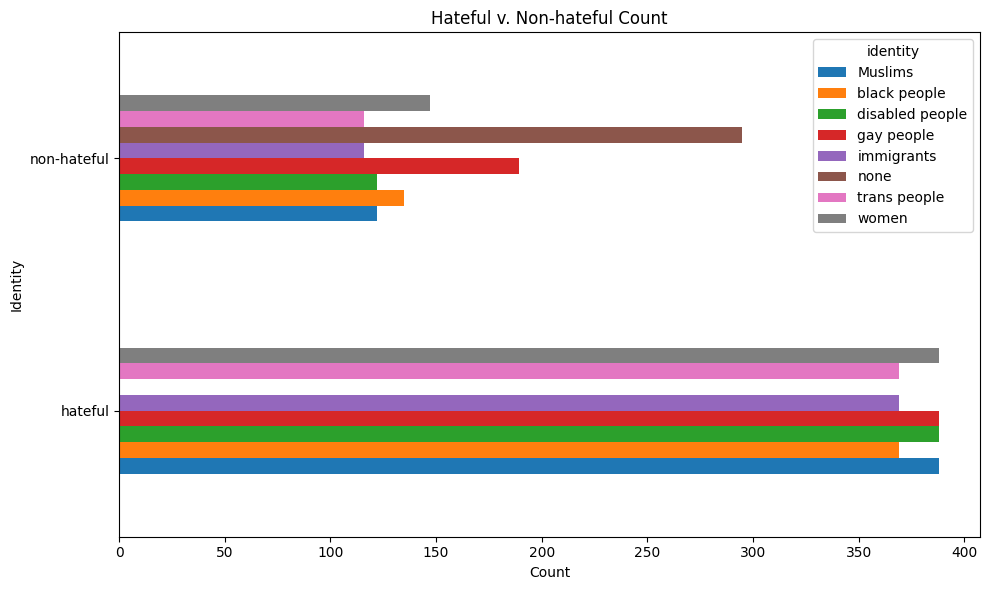

In [1104]:
# create for lopp that loops through each identity and plots two bars, one for hateful and one for non-hateful

fig, ax = plt.subplots(figsize=(10, 6))

identity_label_count.plot(kind='barh', ax=ax)

ax.set_xlabel('Count')
ax.set_ylabel('Identity')
ax.set_title('Hateful v. Non-hateful Count')

plt.tight_layout()
plt.show()


### Applying dictionary to text column


In [1105]:
number_to_letter_dict = {
    "1": "i",
    "3": "e",
    "4": "a",
    "7": "t",
    "0": "o"
}

#loops though dictionary and replaces misspelled words in "text" column
for number_str, letter in number_to_letter_dict.items():
    no_conseq_ints = ~df['text'].str.contains(r'\d{4}') # skips strings that are 4 consequtive ints (for '2020')

    df["text"].loc[no_conseq_ints] = df["text"].loc[no_conseq_ints].str.replace(number_str, letter, regex=False)

#saved rows that were misspelled, so i can find them again after applying change
df["text"].loc[words_with_numbers_validation]

2811              Its disheartening to still see people call for the death of women in 2020 
2812       Its disheartening to still see people call for the death of trans people in 2020 
2813         Its disheartening to still see people call for the death of gay people in 2020 
2814       Its disheartening to still see people call for the death of black people in 2020 
2815    Its disheartening to still see people call for the death of disabled people in 2020 
                                                ...                                         
3896                                                   Gay people are all complete assholes 
3897                                                 Black people are all complete assholes 
3898                                              Disabled people are all complete assholes 
3899                                                      Muslims are all complete assholes 
3900                                                   Immigrants are 

### Sentiment Analysis

In [1106]:
from textblob import TextBlob
df_texts = df["text"]

for text in df_texts:
    blob = TextBlob(text)
    print(f"Text: {text}, Polarity: {blob.sentiment.polarity}, Subjectivity: {blob.sentiment.subjectivity}")

Text: I hate women , Polarity: -0.8, Subjectivity: 0.9
Text: I hate trans people , Polarity: -0.8, Subjectivity: 0.9
Text: I hate gay people , Polarity: -0.19166666666666668, Subjectivity: 0.7416666666666667
Text: I hate black people , Polarity: -0.48333333333333334, Subjectivity: 0.6666666666666667
Text: I hate disabled people , Polarity: -0.5, Subjectivity: 0.6
Text: I hate Muslims , Polarity: -0.8, Subjectivity: 0.9
Text: I hate immigrants , Polarity: -0.8, Subjectivity: 0.9
Text: I really cant stand women like you , Polarity: 0.2, Subjectivity: 0.2
Text: I really cant stand trans people like you , Polarity: 0.2, Subjectivity: 0.2
Text: I really cant stand gay people like you , Polarity: 0.30833333333333335, Subjectivity: 0.3916666666666667
Text: I really cant stand black people like you , Polarity: 0.016666666666666677, Subjectivity: 0.31666666666666665
Text: I really cant stand disabled people like you , Polarity: 0.0, Subjectivity: 0.25
Text: I really cant stand Muslims like you 

### Sentiment Analysis Evaluation:
Thinking that changing all numbers to letters in the words that were affected seemed to do nothing. I still think that the scoring is very off and sentences that are seemingly just as negative score differently. In other words: I can't use this information for anything useful.

## Data Augmentation
- Balance out labels
- Testa Andreas förslag på google translate
    - translate mening till 5-10 andra språk och sedan translate:a tillbaka
- "Paraphrasing tool"?
- sentence shuffling
- gpt3 för generera ny data

*tänk på att kanske endast ha data augmentation i train setet, inte både test och train, blir nog data leakage*


In [1107]:
# finds words that are written with single letters and has spaces inbetween each letter in that word
# ex: "I really l i k e icecream"
pattern = r'(\b(?:[a-zA-Z] ){2,}[a-zA-Z]\b)'

filtered_rows = df[df["text"].str.contains(pattern, regex=True)]

# removes these rows because it was to difficult to change it back to normal
df.drop(filtered_rows.index, inplace=True)

C:\Users\Danne\AppData\Local\Temp\ipykernel_16792\929293293.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_rows = df[df["text"].str.contains(pattern, regex=True)]


In [1108]:
# # test to make sure that this loop works - it does
# int_list_test = []

# for i in range(11):
#     while True:
#         rand_index = random.randint(0, 10)
#         if rand_index not in int_list_test:
#             break

#     int_list_test.append(rand_index)

# int_list_test

In [1109]:
# translator = Translator()
# int_list = []

# for i in range(500):
#     while True:
#         rand_index = random.randint(0, len(df) - 1)
#         if rand_index not in int_list:
#             break

#     int_list.append(rand_index) # append number so same row can show up twice

#     # extract column information to add to new row
#     rand_string = df["text"].iloc[rand_index]
#     label = df["label"].iloc[rand_index]
#     identity = df["identity"].iloc[rand_index]

#     print(f"Original text: {rand_string} Row: {rand_index} Count: {i}")

#     # translation from eng -> korean -> eng -> put sentence on new row for DF
#     translator_text_test = translator.translate(rand_string, dest='ko').text
#     translator_text_test = translator.translate(translator_text_test, dest='en').text

#     print(f"Translated back: {translator_text_test}\n")
#     # column info for new row
#     new_row = {'text': translator_text_test, 'label': label, 'identity': identity}
#     new_row_df = pd.DataFrame([new_row])
#     df = pd.concat([df, new_row_df], ignore_index=True)

#     # Is it possible to speed this process up? ~20 minutes for 500 new rows

Modellen måste kunna först avgöra om texten är hatisk eller inte, sedan ska den välja vilken identitet den isåfall är hatisk emot. Hur ska jag göra detta?
- Kallas tydligen: two-step classification progress

#### Aproaches: 
- Separata modeller: en för binary och en för multiclass
- Singulär modell som gör båda

## Stopwords Removal

In [1110]:
nltk_stopwords = stopwords.words("english")  # set language stopwords

def remove_stopwords_from_df(df: DataFrame) -> str:
    words = df.split()  # only sentences - split makes each row list of words
    filtered_words = [
        word for word in words if word.lower() not in nltk_stopwords
    ]  # keep words that arent in stopword list
    filtered_sentence = " ".join(filtered_words)  # list -> string again
    return filtered_sentence


df["text"] = df["text"].apply(
    remove_stopwords_from_df
)  # each replaced with filtered sentence

## Label Encoding

In [1111]:
df["identity_encoding"] = df["identity"].astype("category").cat.codes
df["label_encoding"] = df["label"].astype("category").cat.codes

df_unique_encodings = df.drop_duplicates(["identity", "identity_encoding"])
df_unique_encodings = df_unique_encodings.drop(columns=["text", "label"])
df_unique_encodings.sort_values(by=["identity_encoding"])

,identity,identity_encoding,label_encoding
5,Muslims,0,0
3,black people,1,0
4,disabled people,2,0
2,gay people,3,0
6,immigrants,4,0
1271,none,5,1
1,trans people,6,0
0,women,7,0


# Data split, tokenization & padding

In [1112]:
X, y = df["text"], df["label_encoding"]

# train test validation split 70/15/15
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42
)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(2608,) (560,) (560,)
(2608,) (560,) (560,)


In [1113]:
# counts how many words there are in dataset - for setting vocab_size
words = list(itertools.chain(*[sentence.split() for sentence in df["text"]]))
word_counts = Counter(words)

len(word_counts)

1268

## Lemmatization

In [1114]:
nltk.download("wordnet")
nltk.download("punkt")

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_tokens)

df['text'] = df['text'].apply(lemmatize_text)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Danne\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Danne\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Tokenization & Padding

In [1115]:
vocab_size = 2000  # since total unique words in dataset are 16926
embedding_dim = 50  # 50-500 seems to be normal range, since this is a smaller dataset, I've gone with 50
max_length = 40  # max length in words - truncated if longer, padded if shorter
padding_type = "post"
trunc_type = "post"

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(
    X_train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type
)
X_val_padded = pad_sequences(
    X_val_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type
)
X_test_padded = pad_sequences(
    X_test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type
)

## First model creation (Binary Classification)

simple model has low amount of parameters (without LSTM)

I'm also properly trying Earlystopping for this model (which I haven't done before), this is because I want to save time and also get the best model that is possible.

Tested LSTM as first RNN layer. worked pretty well, and not too many parameters after adding LSTM with 512 nodes (1.2m). It's also worth noting that I'm using the same setup for the embedding layer as I did for the RNN labb. However, I've changed the variables abit to fit this dataset better:

```py
    model.add(layers.LSTM(512, activation='relu'))
    model.add(Dense(1, activation="sigmoid"))
```

**Parameters:** 1.25M
- Val Accuracy: 0.9589
- Test Accuracy: 0.6482
- Val Loss: 0.4868
- Test Loss: 0.6931

I also wanted to check if the same tactic that I used for labb 2, would work here aswell. Therefor I added conv1d layer and max pooling aswell as an FC layer:

```py
    model.add(layers.Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(layers.MaxPool1D(5))
    model.add(layers.LSTM(512, activation='relu'))
    model.add(Dense(1, activation="sigmoid"))
```

**Parameters:** 1.29M
- Val Accuracy: 0.9661
- Test Accuracy: 0.9607
- Val Loss: 0.5187
- Test Loss: 0.4382

Just because I was curious, I added a second LSTM layer, aswell as an FC layer. I also increased the node count. I wanted to see if just adding more would easily get the model to ~99% val and test accuracy:

```py
    model.add(layers.Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(layers.MaxPool1D(5))
    model.add(layers.LSTM(1024, activation='relu', return_sequences=True))
    model.add(layers.LSTM(512, activation='relu'))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(Dense(1, activation="sigmoid"))
```

**Parameters:** 8.25M 
- Val Accuracy: 0.9500
- Test Accuracy: 0.9375
- Val Loss: 0.1843
- Test Loss: 0.1994

Obviously, this didn't work well, not only increased parameters by almost a factor 8, but test and val accuracy also went down. I removed second LSTM layer and also decreased the amount of nodes for each layer, which seemed to help: 

**Parameters:** 510K
- Val Accuracy: 0.9661
- Test Accuracy: 0.9661
- Val Loss: 0.1755
- Test Loss: 0.1302

```py
    model.add(layers.Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(layers.MaxPool1D(5))
    model.add(layers.LSTM(256, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(Dense(1, activation="sigmoid"))

```

Right now, Early stopping is down to epoch 5, which seems abit low. I want to see if i can extened training for a couple more epochs by adding regularization:

**Parameters:** 580K
- Val Accuracy: 0.9518
- Test Accuracy: 0.9643
- Val Loss: 0.2633
- Test Loss: 0.1903

```py

```

This did not seem to do much outside of extending the Early stopping by 1 epoch. I tested different combinations of Dropout and L2, aswell as different values. However, this did not seem to help in any way.

In [1116]:
def test_base_model():
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=max_length))
    #--------------------------------------------------------------------------------
    model.add(layers.Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(layers.MaxPool1D(5))
    model.add(layers.LSTM(256, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(Dense(1, activation="sigmoid"))
    #--------------------------------------------------------------------------------
    model.add(Dense(1, activation="sigmoid"))
    return model

test_binary_model = test_base_model()
test_binary_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
test_binary_model.summary()

Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_70 (Embedding)    (None, 40, 50)            100000    
                                                                 
 conv1d_69 (Conv1D)          (None, 36, 64)            16064     
                                                                 
 max_pooling1d_69 (MaxPooli  (None, 7, 64)             0         
 ng1D)                                                           
                                                                 
 lstm_92 (LSTM)              (None, 256)               328704    
                                                                 
 dense_156 (Dense)           (None, 256)               65792     
                                                                 
 dense_157 (Dense)           (None, 1)                 257       
                                                     

In [1117]:
def base_model():
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(layers.Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(layers.MaxPool1D(5))
    model.add(layers.LSTM(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))
    return model

binary_model = base_model()
binary_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
binary_model.summary()

Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_71 (Embedding)    (None, 40, 50)            100000    
                                                                 
 conv1d_70 (Conv1D)          (None, 36, 64)            16064     
                                                                 
 max_pooling1d_70 (MaxPooli  (None, 7, 64)             0         
 ng1D)                                                           
                                                                 
 lstm_93 (LSTM)              (None, 256)               328704    
                                                                 
 dropout_38 (Dropout)        (None, 256)               0         
                                                                 
 dense_159 (Dense)           (None, 512)               131584    
                                                     

In [1118]:
print("X_train_padded shape:", X_train_padded.shape)
print("y_train shape:", y_train.shape)
print("X_val_padded shape:", X_val_padded.shape)
print("y_val shape:", y_val.shape)
print("X_test_padded shape:", X_test_padded.shape)
print("y_test shape:", y_test.shape)

X_train_padded shape: (2608, 40)
y_train shape: (2608,)
X_val_padded shape: (560, 40)
y_val shape: (560,)
X_test_padded shape: (560, 40)
y_test shape: (560,)


Epoch 1/10


82/82 [==============================] - 3s 18ms/step - loss: 0.8467 - accuracy: 0.6714 - val_loss: 0.6709 - val_accuracy: 0.6661
Epoch 2/10
82/82 [==============================] - 1s 16ms/step - loss: 0.5554 - accuracy: 0.7538 - val_loss: 0.3843 - val_accuracy: 0.8786
Epoch 3/10
82/82 [==============================] - 1s 15ms/step - loss: 0.1623 - accuracy: 0.9536 - val_loss: 0.1847 - val_accuracy: 0.9536
Epoch 4/10
82/82 [==============================] - 1s 15ms/step - loss: 0.0729 - accuracy: 0.9804 - val_loss: 0.2199 - val_accuracy: 0.9625
Epoch 4: early stopping


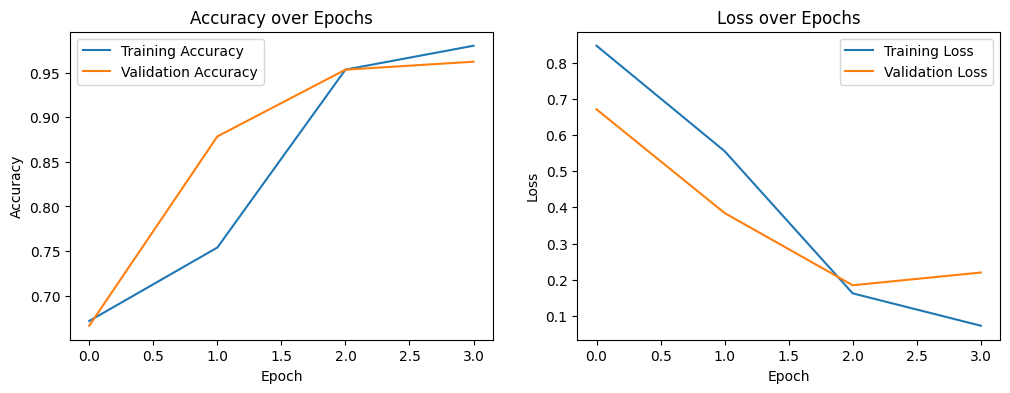

In [1119]:
epochs = 10
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1) # verbose print epoch stop number
history = binary_model.fit(X_train_padded, y_train, epochs=epochs, validation_data=(X_val_padded, y_val), callbacks=[es])

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [1120]:
test_loss, test_accuracy = binary_model.evaluate(X_test_padded, y_test)
val_loss, val_accuracy = history.history['val_loss'][-1], history.history['val_accuracy'][-1]

print("**Parameters:** ")
print(f"- Val Accuracy: {val_accuracy:.4f}")
print(f"- Test Accuracy: {test_accuracy:.4f}")
print(f"- Val Loss: {val_loss:.4f}")
print(f"- Test Loss: {test_loss:.4f}")


10/18 [===============>..............] - ETA: 0s - loss: 0.1386 - accuracy: 0.9719

18/18 [==============================] - 0s 6ms/step - loss: 0.1952 - accuracy: 0.9625
**Parameters:** 
- Val Accuracy: 0.9625
- Test Accuracy: 0.9625
- Val Loss: 0.2199
- Test Loss: 0.1952
